<a href="https://colab.research.google.com/github/arnav-meduri/JCVI-Syn3A-analysis/blob/main/Pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 2023-06
# Deep Learning
# Basic Classification


## Implementing an MLP and LeNet for MNIST classification

#### Sections:
1. Load and display MNIST Dataset
2. Implement a MLP
2. LeNet - Simple Image Classification Using the MNIST Dataset - Pytorch
3. VGG11 - A More Deeper Model!
4.  TensorFlow LeNet - Simple Image Classification Using the MNIST Dataset (Optional)

### Import the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

import tensorflow.keras.datasets.mnist as MNIST

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

%config Completer.use_jedi = False

In [2]:
import tensorflow.keras.datasets.mnist as MNIST

#### Check GPU availability (should be False if you run without GPU Accelerator, to turn it on, go to Settings->Accelerator on the right panel and select GPU).

In [3]:
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

GPU available: True


#### Set the random seed for reproducibility.

The random seed helps to make sure that the model parameter initialization, sequence of random shuffling, and most other nondeterministic operations are kept the same each time you run this notebook.

In [4]:
torch.manual_seed(4460)
np.random.seed(4460)

## 1. Load and display MNIST Dataset

#### Download the MNIST handwritten digits dataset.

The MNIST dataset is designed to have a 60k-image train set and a 10k-image test set. We are not going to use all of them for this tutorial because that will eat up quite a bit of memory.

In [5]:
(image_MNIST_train_set, label_MNIST_train_set), (image_MNIST_test_set, label_MNIST_test_set) = MNIST.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [6]:
image_MNIST_test_set.size





7840000

#### Display some sample images and labels.

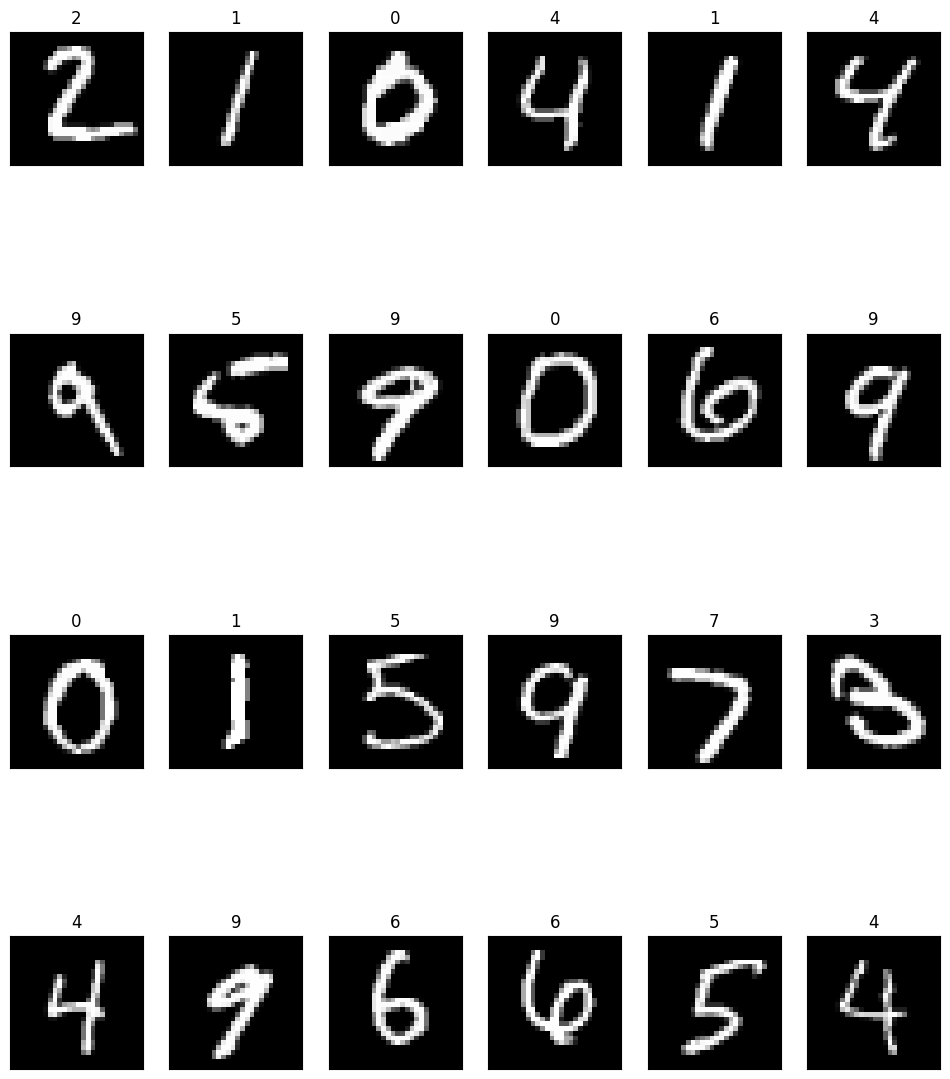

In [7]:
row = 4
col = 6
fig = plt.figure(figsize = (12, 15))

for image_index in range(1, row * col + 1):
    image = image_MNIST_test_set[image_index, :, :]
    ax = fig.add_subplot(row, col, image_index)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(str(label_MNIST_test_set[image_index]))
    plt.imshow(image, cmap = 'gray')

plt.show()

#### We have 70k images in total, but we will only use a subset of it for this tutorial.

Let's just use what MNIST originally allocated as the test set as our entire dataset (N = 10k) and perform a 8:1:1 train:validation:test split.

In [8]:
# Split the 10000 MNIST test set into our train set (N = 8e3) and validation+test set (N = 2e3) at an 8:2 ratio.
indices_train, indices_validation_and_test = train_test_split(range(len(image_MNIST_test_set)), test_size = 0.2)
image_train = image_MNIST_test_set[indices_train, :, :]
label_train = label_MNIST_test_set[indices_train]
image_validation_and_test = image_MNIST_test_set[indices_validation_and_test, :, :]
label_validation_and_test = label_MNIST_test_set[indices_validation_and_test]

# Split the validation+test set into the validation set (N = 5e3) and the test set (N = 5e3).
# Note that we are using the package "train_test_split" but what we are actually doing here is validation test split.
indices_validation, indices_test = train_test_split(range(len(image_validation_and_test)), test_size = 0.5)
image_validation = image_validation_and_test[indices_validation, :, :]
label_validation = label_validation_and_test[indices_validation]
image_test = image_validation_and_test[indices_test, :, :]
label_test = label_validation_and_test[indices_test]

print('Images: train %d, validation %d, test %d \nLabels: train %d, validation %d, test %d' % \
      (len(image_train), len(image_validation), len(image_test), len(label_train), len(label_validation), len(label_test)))

Images: train 8000, validation 1000, test 1000 
Labels: train 8000, validation 1000, test 1000


#### Reformat the images and labels so that they can be fed into the data loader.
Normally you would construct a validation loader and a test loader similar to how we construct the train loader, but for this case since the validation and test set only consists of 1000 28$\times$28 images each, we can just get away with not using a data loader at all.

In [9]:
image_train_torch = torch.from_numpy(image_train).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_train_torch = torch.from_numpy(label_train).type(torch.LongTensor)

image_validation_torch = torch.from_numpy(image_validation).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_validation_torch = torch.from_numpy(label_validation).type(torch.LongTensor)

image_test_torch = torch.from_numpy(image_test).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_test_torch = torch.from_numpy(label_test).type(torch.LongTensor)

train_data = TensorDataset(image_train_torch, label_train_torch)
train_loader = DataLoader(train_data, batch_size = 1000)

## 2. Implement a MLP

### Build our MLP network.

The architecture would be a two hidden layer MLP with a sigmoid activation function.

The first layer will have 128 artificial neurons, and the second layer will have 64 artificial neurons.

The last layer (output layer) will have ten neurons and a SoftMax activation function to generate the probability of the input belonging to each of the ten categories.

<div align="center">
  <img src="https://github.com/soroush361/AoE_BME/blob/main/MLP_Arc.png?raw=true" />
</div>

In [10]:
class MLPModel(nn.Module):
    '''Reshape -> FC -> Sigmoid -> FC -> Sigmoid -> FC -> SoftMax -> Cross-Entropy'''
    def __init__(self):
        '''Define model modules.'''
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

our_MLP = MLPModel()

# If GPU available, move the model to GPU.
if cuda:
    our_MLP.cuda()

print(our_MLP)

MLPModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


#### Define our optimizer.

In [11]:
# define our optimizer
optimizer = SGD(our_MLP.parameters(), lr = 0.1)

#### Create a folder to save our trained model by the end of each epoch.

In [12]:
!mkdir saved_models_MLP

### Train our MLP model for classification.

In [13]:
EPOCHS = 400

# Two lists to keep the losses at the end of each epoch.
train_epoch_loss = list()
validation_epoch_loss = list()

for epoch in range(EPOCHS):

    # A dummy list to keep the losses at the end of each iteration (one bacth forward and backward process).
    train_loss = list()

    #######################################################
    ################### Training Loop #####################
    #######################################################

    # Set the model to train mode so that the parameters can be updated.
    our_MLP.train()

    for batch_index, (train_image, train_label) in enumerate(train_loader):
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
#             print(type(train_))
            train_label_predicted = our_MLP(train_image.cuda())

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label.cuda())
            train_loss.append(loss.cpu().data.item())

            # reset the gradient
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

        # If GPU is not available.
        else:
            train_label_predicted = our_MLP(train_image)

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label)
            train_loss.append(loss.data.item())

            # reset the gradient
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

    # Take the average of iteration losses and append it to the epoch losses list
    train_epoch_loss.append(np.mean(train_loss))


    #######################################################
    #################### validation #######################
    #######################################################

    # Set the model to evaluation mode so that parameters are fixed.
    our_MLP.eval()

    # Since number of samples in validation is not that large, we can call the model on the whole set at once (No need for looping through samples!)

    # If GPU is available, move the data to the GPU for faster computation.
    if cuda:
        validation_label_predicted = our_MLP(image_validation_torch.cuda())
        loss = F.cross_entropy(validation_label_predicted, label_validation_torch.cuda())
        validation_epoch_loss.append(loss.cpu().data.item())

    # If GPU is not available.
    else:
        validation_label_predicted = our_MLP(image_validation_torch)
        loss = F.cross_entropy(validation_label_predicted, label_validation_torch.cuda())
        validation_epoch_loss.append(loss.data.item())

    # save models
    torch.save(our_MLP.state_dict(), './saved_models_MLP/checkpoint_epoch_%s.pth' % (epoch))

    print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

Epoch: 0 | train_loss: 2.2980957627296448 | validation_loss: 2.263437509536743
Epoch: 1 | train_loss: 2.241784542798996 | validation_loss: 2.2201597690582275
Epoch: 2 | train_loss: 2.201993703842163 | validation_loss: 2.1811628341674805
Epoch: 3 | train_loss: 2.1625896394252777 | validation_loss: 2.1390721797943115
Epoch: 4 | train_loss: 2.1189315021038055 | validation_loss: 2.0923068523406982
Epoch: 5 | train_loss: 2.070574641227722 | validation_loss: 2.0403318405151367
Epoch: 6 | train_loss: 2.0167498886585236 | validation_loss: 1.98432195186615
Epoch: 7 | train_loss: 1.9581127613782883 | validation_loss: 1.9218637943267822
Epoch: 8 | train_loss: 1.8932758569717407 | validation_loss: 1.854519248008728
Epoch: 9 | train_loss: 1.8237589001655579 | validation_loss: 1.7832434177398682
Epoch: 10 | train_loss: 1.751127228140831 | validation_loss: 1.7097699642181396
Epoch: 11 | train_loss: 1.6764140129089355 | validation_loss: 1.6354762315750122
Epoch: 12 | train_loss: 1.6015400439500809 | v

In [14]:
for batch_index, (train_image, train_label) in enumerate(train_loader):

            train_label_predicted = our_MLP(train_image.cuda())


### Explanation on train, validation and test split.
While you are waiting for your MLP to be trained, let's look back on what it means to and why we need to perform a train/validation/test split.

- The train set is quite straightforward: you allocate a portion of the data to train your model.
- The test set is a set of data you keep to yourself and make sure the model doesn't have access to. You need that set of data to evaluate the performance of your model once it is ready to be challenged.
- The validation set is a set of data you quiz your model before it is ready for the "final exam" given by the test set. It gives you an idea how well the model is likely to perform on an unseen set of data.

In an ideal case, you design and train your model using the train data, adjust the hyperparameters (learning rate, etc.) and decide on when to stop the training (either by adjusting # epoch or by setting automated criteria for early stop) along with other intelligent approaches to make sure the model is likely to generalize well, and then test its performance on the test data.

#### Draw the train loss and validation loss curves.

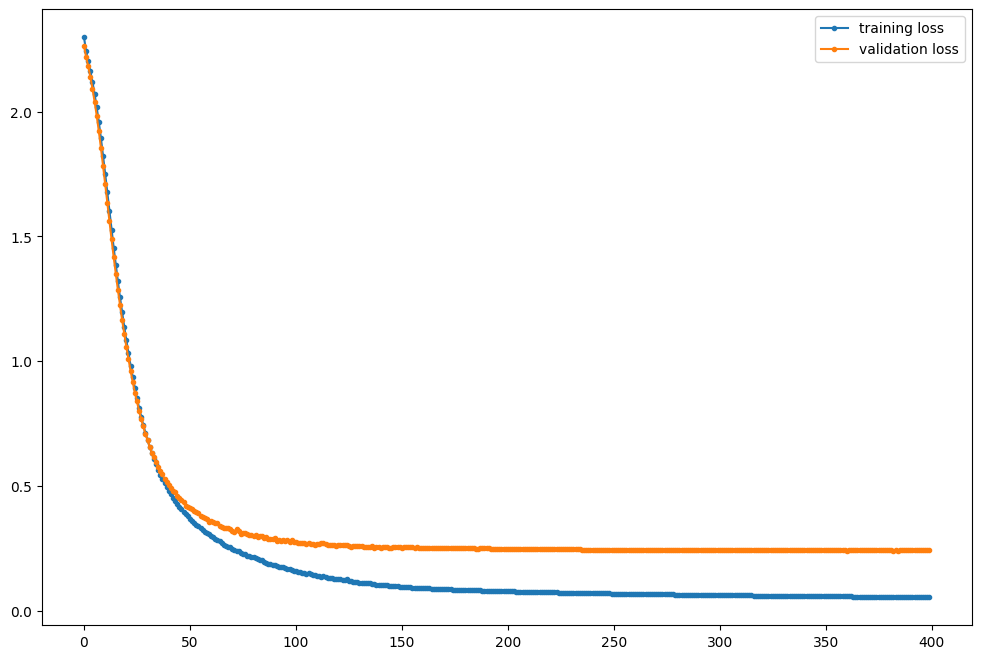

In [15]:
plt.figure(figsize = (12, 8))
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
plt.plot(validation_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');

#### Let's check at which epoch the model performs the best on the validation set.

In [16]:
best_epoch = np.argmin(validation_epoch_loss)
print('best epoch: ', best_epoch)

best epoch:  384


#### Let's look at the best epoch more closely.

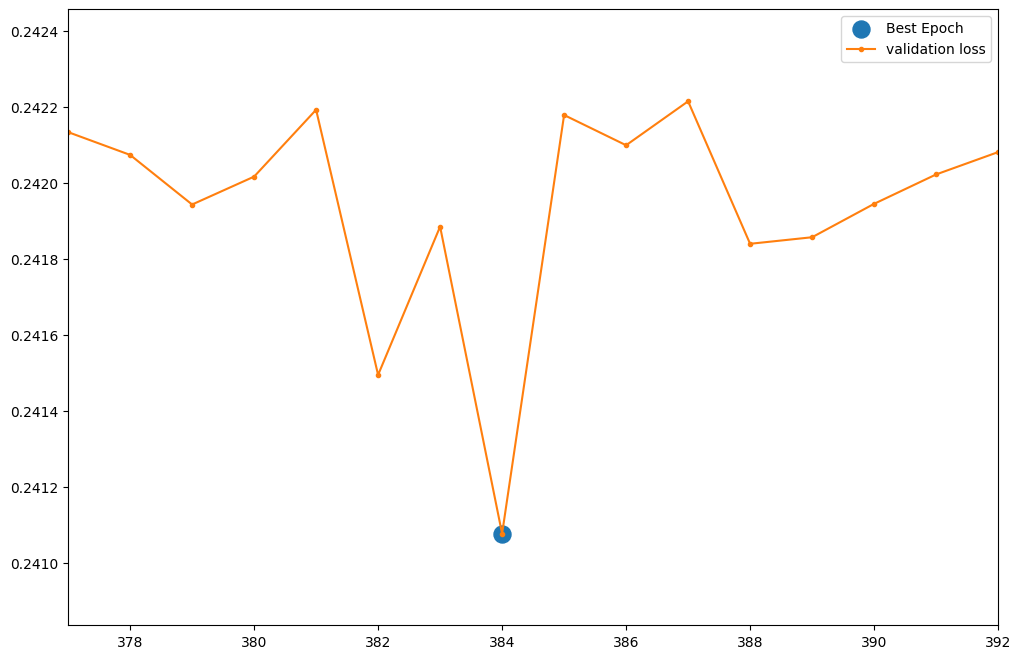

In [17]:
plt.figure(figsize = (12, 8))
plt.scatter(x=best_epoch, y=validation_epoch_loss[best_epoch], c='tab:blue', s = 150, label='Best Epoch')
plt.plot(validation_epoch_loss, '-o', label = 'validation loss', c='tab:orange', markersize = 3)
plt.xlim([best_epoch-7, best_epoch+8])
plt.ylim([min(validation_epoch_loss[best_epoch-7:best_epoch+8])*0.999,
          max(validation_epoch_loss[best_epoch-7:best_epoch+8])*1.001])
plt.legend(loc = 'upper right');

#### We will call that as our best model and use that for inference on the test set.

In [18]:
state_dict = torch.load('./saved_models_MLP/checkpoint_epoch_%s.pth' % (best_epoch))
print(state_dict.keys())
our_MLP.load_state_dict(state_dict)

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


<All keys matched successfully>

### Predict the labels on the test set.

#### 1. Do that on a sample image.

In [19]:
def view_classify(image, probabilities, version = "MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize = (6, 9), ncols = 2)
    ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze(), cmap = 'gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.bar(np.arange(10), probabilities)
    ax2.set_aspect(10)
    ax2.set_xticks(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_ylim(0, 1.1)

    plt.tight_layout()

In [20]:
our_MLP.eval()

sample_test_image = image_test_torch[0, :, :, :][np.newaxis, :, :, :]

if cuda:
    sample_prediction = our_MLP(sample_test_image.cuda())
else:
    sample_prediction = our_MLP(sample_test_image)

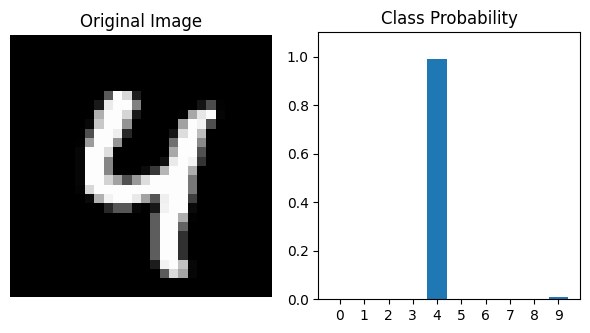

In [21]:
warnings.filterwarnings("ignore")

if cuda:
    view_classify(sample_test_image, np.e ** sample_prediction.cpu())
else:
    view_classify(sample_test_image, np.e ** sample_prediction)

#### 2. This one is good, but what is the overall performance?

In [22]:
def predict_with_pytorch(model, input_data):
    model.eval()
    label_predicted_all = []

    label_predicted_one_hot = model(input_data)
    label_predicted_probability, label_predicted_index = torch.max(label_predicted_one_hot.data, 1)

    for current_prediction in label_predicted_index:
        label_predicted_all.append(current_prediction.detach().cpu().numpy().item())

    return label_predicted_all

In [23]:
if cuda:
    test_label_predicted = predict_with_pytorch(our_MLP, image_test_torch.cuda())
else:
    test_label_predicted = predict_with_pytorch(our_MLP, image_test_torch)

accuracy = accuracy_score(label_test, test_label_predicted)

print("Accuracy:", accuracy * 100, "%")

Accuracy: 92.2 %


As you can see, the MLP model is performing well but not perfect on the MNIST classification.

#### 3. Lastly, can I have a more intuitive (and cooler) way to visualize the performance?

#### Yes! The answer is a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)!

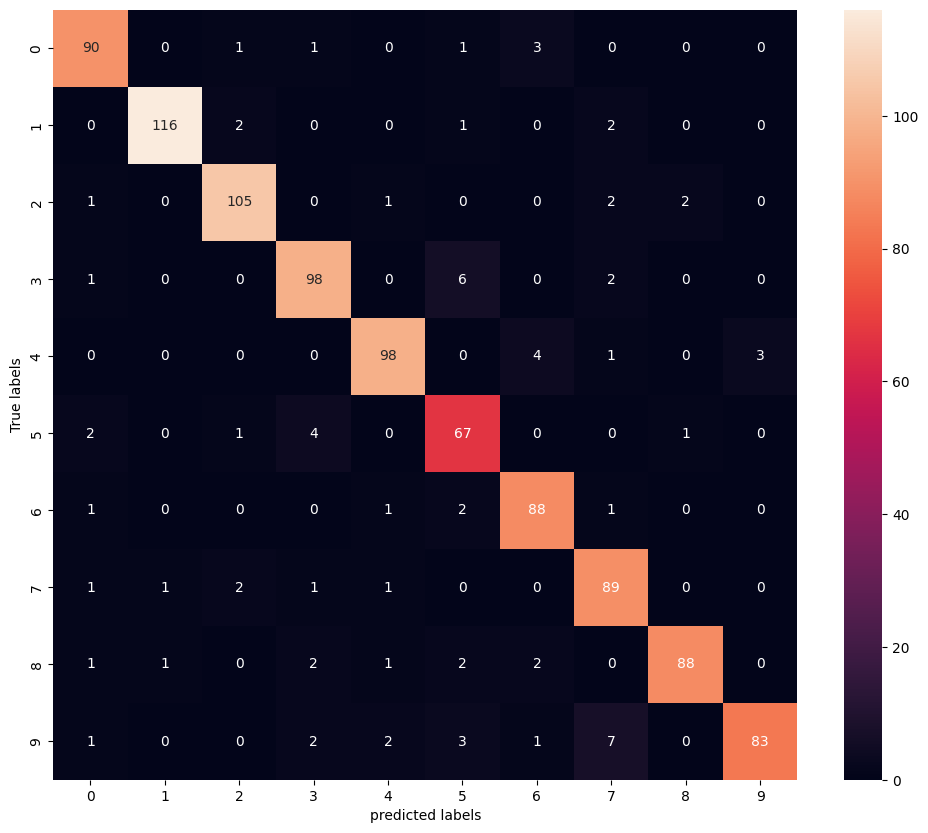

In [24]:
CM = confusion_matrix(label_test, test_label_predicted)

plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');

## 3. LeNet - Simple Image Classification Using the MNIST Dataset - Pytorch
This notebook is inspired by and largely adapted from this repository ["RnR-2018/BMEN4460-NB2-image_classification_on_MNIST_data"](https://github.com/RnR-2018/BMEN4460-NB2-image_classification_on_MNIST_data) and its parent repository ["RnR-2018/Deep-learning-with-PyTorch-and-GCP"](https://github.com/RnR-2018/Deep-learning-with-PyTorch-and-GCP).

Thanks to **Nanyan "Rosalie" Zhu** and **Chen "Raphael" Liu**.

### Build our classification network.

We will implement version 5 of the LeNet.


<div align="center">
  <img src="https://github.com/soroush361/AoE_BME/blob/main/LeNet5_1.png?raw=true" />
</div>

In [25]:
# Formula to calculate shape as we go through layer by layer = [(X - F + 2P)/S] + 1
# Here,
# X = Width / Height
# F = Kernel size
# P = Padding
# S = Strides (default = 1)

# Our input to the first layer is going to be [batchsize, 1, 28, 28]
# substitute, =[(28 - 5 + 2(0))/1] + 1
#             =[(23)/1] + 1
#             =23 + 1
#             =24


class LeNet5Model(nn.Module):
    '''ConvNet -> ReLU -> Max_Pool -> ConvNet -> ReLU -> Max_Pool -> Reshape -> FC -> Sigmoid -> FC -> Sigmoid -> FC -> SoftMax -> Cross-Entropy'''
    def __init__(self):
        '''Define model modules.'''
        super(LeNet5Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 16)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

our_LeNet = LeNet5Model()

# If GPU available, move the model to GPU.
if cuda:
    our_LeNet.cuda()

print(our_LeNet)

LeNet5Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### Define our optimizer.

In [26]:
# define our optimizer
optimizer = SGD(our_LeNet.parameters(), lr = 0.1)

#### Create a folder to save our trained model by the end of each epoch.

In [27]:
!mkdir saved_models_LeNet

### Train our LeNet-5 for MNIST classification.

In [28]:
EPOCHS = 400

# Two lists to keep the losses at the end of each epoch.
train_epoch_loss = list()
validation_epoch_loss = list()

for epoch in range(EPOCHS):

    # A dummy list to keep the losses at the end of each iteration (one bacth forward and backward process).
    train_loss = list()

    #######################################################
    ################### Training Loop #####################
    #######################################################

    # Set the model to train mode so that the parameters can be updated.
    our_LeNet.train()

    for batch_index, (train_image, train_label) in enumerate(train_loader):
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
            train_label_predicted = our_LeNet(train_image.cuda())

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label.cuda())
            train_loss.append(loss.cpu().data.item())

            # reset the gradient
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

        # If GPU is not available.
        else:
            train_label_predicted = our_LeNet(train_image)

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label)
            train_loss.append(loss.data.item())

            # reset the gradient
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

    # Take the average of iteration losses and append it to the epoch losses list
    train_epoch_loss.append(np.mean(train_loss))


    #######################################################
    #################### validation #######################
    #######################################################

    # Set the model to evaluation mode so that parameters are fixed.
    our_LeNet.eval()

    # Since number of samples in validation is not that large, we can call the model on the whole set at once (No need for looping through samples!)

    # If GPU is available, move the data to the GPU for faster computation.
    if cuda:
        validation_label_predicted = our_LeNet(image_validation_torch.cuda())
        loss = F.cross_entropy(validation_label_predicted, label_validation_torch.cuda())
        validation_epoch_loss.append(loss.cpu().data.item())

    # If GPU is not available.
    else:
        validation_label_predicted = our_LeNet(image_validation_torch)
        loss = F.cross_entropy(validation_label_predicted, label_validation_torch.cuda())
        validation_epoch_loss.append(loss.data.item())

    # save models
    torch.save(our_LeNet.state_dict(), './saved_models_LeNet/checkpoint_epoch_%s.pth' % (epoch))

    print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

Epoch: 0 | train_loss: 2.3061890304088593 | validation_loss: 2.279980182647705
Epoch: 1 | train_loss: 2.269633859395981 | validation_loss: 2.2582807540893555
Epoch: 2 | train_loss: 2.2493824660778046 | validation_loss: 2.2372684478759766
Epoch: 3 | train_loss: 2.2279210090637207 | validation_loss: 2.2150728702545166
Epoch: 4 | train_loss: 2.204840123653412 | validation_loss: 2.1898210048675537
Epoch: 5 | train_loss: 2.1796930730342865 | validation_loss: 2.1631362438201904
Epoch: 6 | train_loss: 2.1537238359451294 | validation_loss: 2.1364645957946777
Epoch: 7 | train_loss: 2.1265147030353546 | validation_loss: 2.1045916080474854
Epoch: 8 | train_loss: 2.0917582511901855 | validation_loss: 2.0680124759674072
Epoch: 9 | train_loss: 2.0550409257411957 | validation_loss: 2.0332305431365967
Epoch: 10 | train_loss: 2.0170865803956985 | validation_loss: 1.9881938695907593
Epoch: 11 | train_loss: 1.9717936664819717 | validation_loss: 1.9392935037612915
Epoch: 12 | train_loss: 1.930822715163231

#### Learning curves.

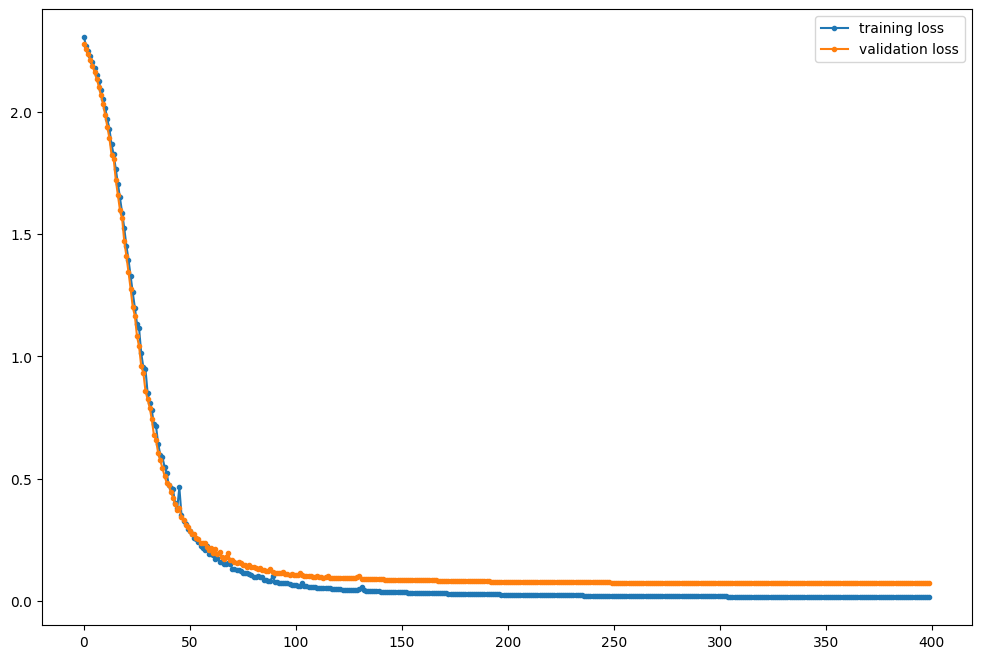

In [29]:
plt.figure(figsize = (12, 8))
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
plt.plot(validation_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');

#### Best epoch

In [30]:
best_epoch = np.argmin(validation_epoch_loss)
print('best epoch: ', best_epoch)

best epoch:  363


#### Load the best model

In [31]:
state_dict = torch.load('./saved_models_LeNet/checkpoint_epoch_%s.pth' % (best_epoch))
print(state_dict.keys())
our_LeNet.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


<All keys matched successfully>

### Predict the labels on the test set.

#### 1. One sample image.

In [32]:
our_LeNet.eval()

sample_test_image = image_test_torch[0, :, :, :][np.newaxis, :, :, :]

if cuda:
    sample_prediction = our_LeNet(sample_test_image.cuda())
else:
    sample_prediction = our_LeNet(sample_test_image)

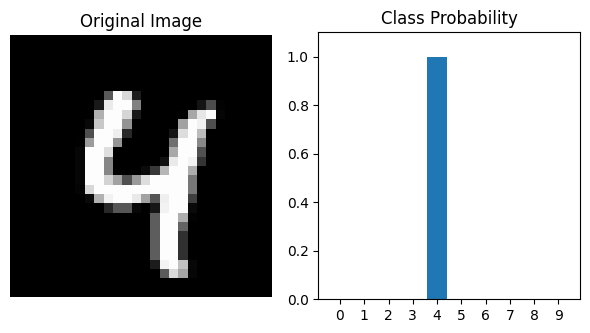

In [33]:
warnings.filterwarnings("ignore")

if cuda:
    view_classify(sample_test_image, np.e ** sample_prediction.cpu())
else:
    view_classify(sample_test_image, np.e ** sample_prediction)

#### 2. Overall performance

In [34]:
if cuda:
    test_label_predicted = predict_with_pytorch(our_LeNet, image_test_torch.cuda())
else:
    test_label_predicted = predict_with_pytorch(our_LeNet, image_test_torch)

accuracy = accuracy_score(label_test, test_label_predicted)

print("Accuracy:", accuracy * 100, "%")

Accuracy: 97.0 %


#### 3. Confusion_matrix

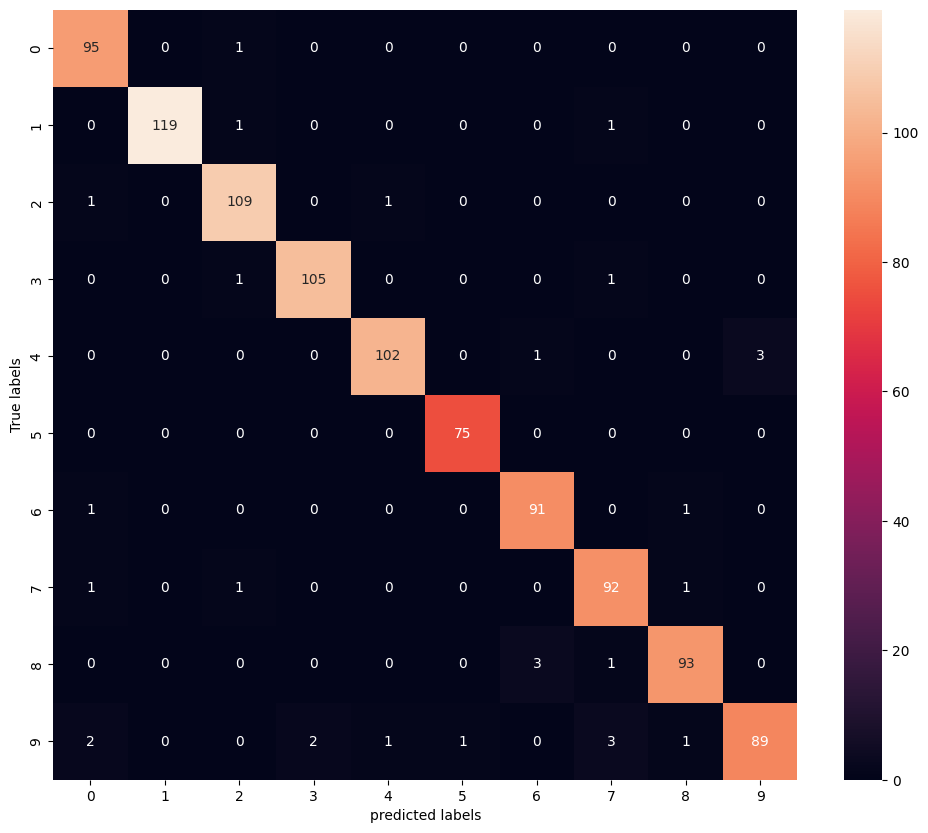

In [35]:
CM = confusion_matrix(label_test, test_label_predicted)

plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');

## 3. VGG11 - A More Deeper Model!



In [36]:
# the VGG11 architecture
class VGG11(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(self.in_channels, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # This is convolution block 5
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*1*1, out_features=1024),
            nn.ReLU(),
#             nn.Dropout2d(0.5),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
#             nn.Dropout2d(0.5),
            nn.Linear(in_features=1024, out_features=self.num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return F.log_softmax(x, dim = 1)

our_VGG = VGG11(1)
if cuda:
    our_VGG.cuda()

#### Define our optimizer.

In [37]:
# define our optimizer
optimizer = SGD(our_VGG.parameters(), lr = 0.01)

#### Create a folder to save our trained model by the end of each epoch.

In [38]:
!mkdir saved_models_VGG

### Train our VGG11 for MNIST classification.
The [VGG paper](https://arxiv.org/abs/1409.1556).

A good explaination for VGG: https://paperswithcode.com/method/vgg
<div align="center">
  <img src="https://github.com/soroush361/AoE_BME/blob/main/VGG_PaperTitle.png?raw=true" />
</div>

<div align="center">
  <img src="https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png" />
</div>

Let's check out the VGG11 architecture performance!

<div align="center">
  <img src="https://github.com/soroush361/AoE_BME/blob/main/VGG11.png?raw=true" />
</div>

In [39]:
EPOCHS = 400

# Two lists to keep the losses at the end of each epoch.
train_epoch_loss = list()
validation_epoch_loss = list()

for epoch in range(EPOCHS):

    # A dummy list to keep the losses at the end of each iteration (one bacth forward and backward process).
    train_loss = list()

    #######################################################
    ################### Training Loop #####################
    #######################################################

    # Set the model to train mode so that the parameters can be updated.
    our_VGG.train()

    for batch_index, (train_image, train_label) in enumerate(train_loader):
        # If GPU is available, move the data to the GPU for faster computation.
        train_image = F.pad(train_image, (2,2,2,2))
        if cuda:
            train_label_predicted = our_VGG(train_image.cuda())

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label.cuda())
            train_loss.append(loss.cpu().data.item())

            # reset the gradient
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

        # If GPU is not available.
        else:
            train_label_predicted = our_VGG(train_image)

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label)
            train_loss.append(loss.data.item())

            # reset the gradient
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

    # Take the average of iteration losses and append it to the epoch losses list
    train_epoch_loss.append(np.mean(train_loss))


    #######################################################
    #################### validation #######################
    #######################################################

    # Set the model to evaluation mode so that parameters are fixed.
    our_VGG.eval()

    # Since number of samples in validation is not that large, we can call the model on the whole set at once (No need for looping through samples!)

    # If GPU is available, move the data to the GPU for faster computation.
    image_validation = F.pad(image_validation_torch, (2,2,2,2))
    if cuda:
        validation_label_predicted = our_VGG(image_validation.cuda())
        loss = F.cross_entropy(validation_label_predicted, label_validation_torch.cuda())
        validation_epoch_loss.append(loss.cpu().data.item())

    # If GPU is not available.
    else:
        validation_label_predicted = our_VGG(image_validation)
        loss = F.cross_entropy(validation_label_predicted, label_validation_torch.cuda())
        validation_epoch_loss.append(loss.data.item())

    # save models
    torch.save(our_VGG.state_dict(), './saved_models_VGG/checkpoint_epoch_%s.pth' % (epoch))

    print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

Epoch: 0 | train_loss: 2.3028512001037598 | validation_loss: 2.3019962310791016
Epoch: 1 | train_loss: 2.30237078666687 | validation_loss: 2.301527500152588
Epoch: 2 | train_loss: 2.3018677830696106 | validation_loss: 2.301034688949585
Epoch: 3 | train_loss: 2.3013563752174377 | validation_loss: 2.3005542755126953
Epoch: 4 | train_loss: 2.3008496165275574 | validation_loss: 2.300079584121704
Epoch: 5 | train_loss: 2.300346314907074 | validation_loss: 2.299612283706665
Epoch: 6 | train_loss: 2.2998476922512054 | validation_loss: 2.2991409301757812
Epoch: 7 | train_loss: 2.2993474304676056 | validation_loss: 2.2986671924591064
Epoch: 8 | train_loss: 2.298842638731003 | validation_loss: 2.2981832027435303
Epoch: 9 | train_loss: 2.298328071832657 | validation_loss: 2.297685384750366
Epoch: 10 | train_loss: 2.2978018820285797 | validation_loss: 2.297170400619507
Epoch: 11 | train_loss: 2.2972586154937744 | validation_loss: 2.2966322898864746
Epoch: 12 | train_loss: 2.29669588804245 | valida

#### Learning curves.

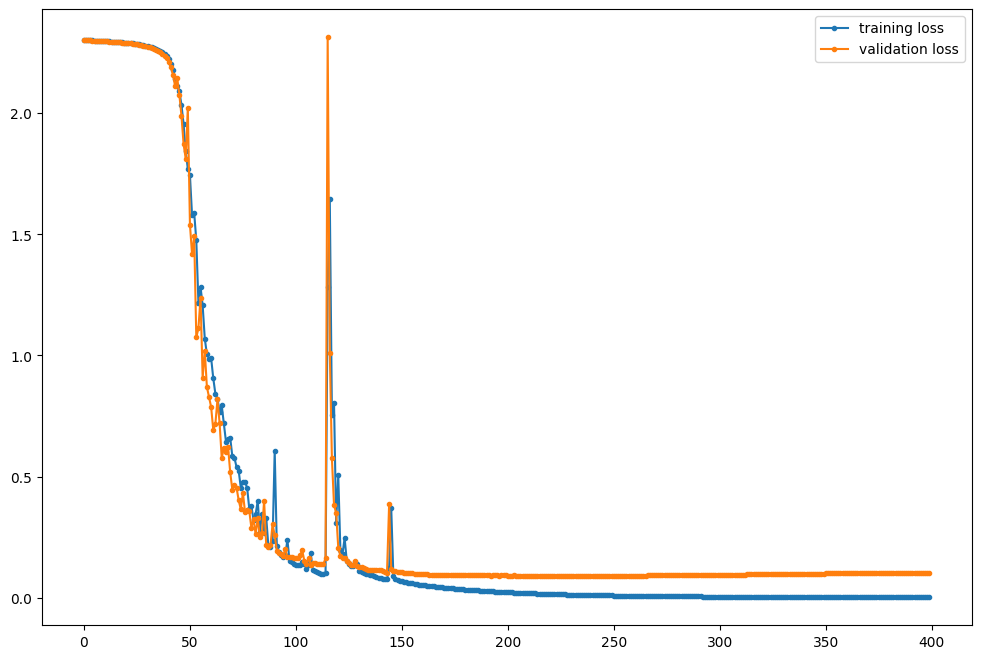

In [40]:
plt.figure(figsize = (12, 8))
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
plt.plot(validation_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');

#### Best epoch

In [41]:
best_epoch = np.argmin(validation_epoch_loss)
print('best epoch: ', best_epoch)

best epoch:  238


#### Load the best model

In [42]:
state_dict = torch.load('./saved_models_VGG/checkpoint_epoch_%s.pth' % (best_epoch))
print(state_dict.keys())
our_VGG.load_state_dict(state_dict)

odict_keys(['conv_layers.0.weight', 'conv_layers.0.bias', 'conv_layers.3.weight', 'conv_layers.3.bias', 'conv_layers.6.weight', 'conv_layers.6.bias', 'conv_layers.8.weight', 'conv_layers.8.bias', 'conv_layers.11.weight', 'conv_layers.11.bias', 'conv_layers.13.weight', 'conv_layers.13.bias', 'conv_layers.16.weight', 'conv_layers.16.bias', 'conv_layers.18.weight', 'conv_layers.18.bias', 'linear_layers.0.weight', 'linear_layers.0.bias', 'linear_layers.2.weight', 'linear_layers.2.bias', 'linear_layers.4.weight', 'linear_layers.4.bias'])


<All keys matched successfully>

### Predict the labels on the test set.

#### 1. One sample image.

In [43]:
our_VGG.eval()

sample_test_image = image_test_torch[0, :, :, :][np.newaxis, :, :, :]

padded_sample_test_image = F.pad(sample_test_image, (2,2,2,2))

if cuda:
    sample_prediction = our_VGG(padded_sample_test_image.cuda())
else:
    sample_prediction = our_VGG(padded_sample_test_image)

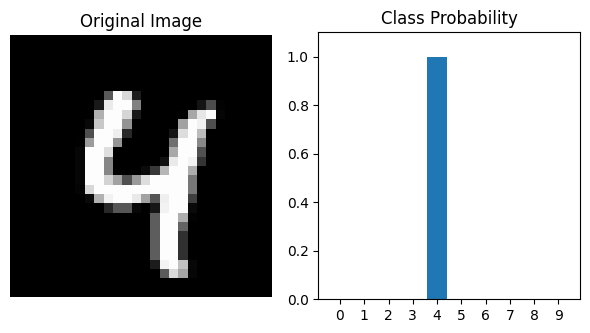

In [44]:
warnings.filterwarnings("ignore")

if cuda:
    view_classify(sample_test_image, np.e ** sample_prediction.cpu())
else:
    view_classify(sample_test_image, np.e ** sample_prediction)

#### 2. Overall performance

In [45]:
image_test = F.pad(image_test_torch, (2,2,2,2))
if cuda:
    test_label_predicted = predict_with_pytorch(our_VGG, image_test.cuda())
else:
    test_label_predicted = predict_with_pytorch(our_VGG, image_test)

accuracy = accuracy_score(label_test, test_label_predicted)

print("Accuracy:", accuracy * 100, "%")

Accuracy: 96.7 %


#### 3. Confusion_matrix

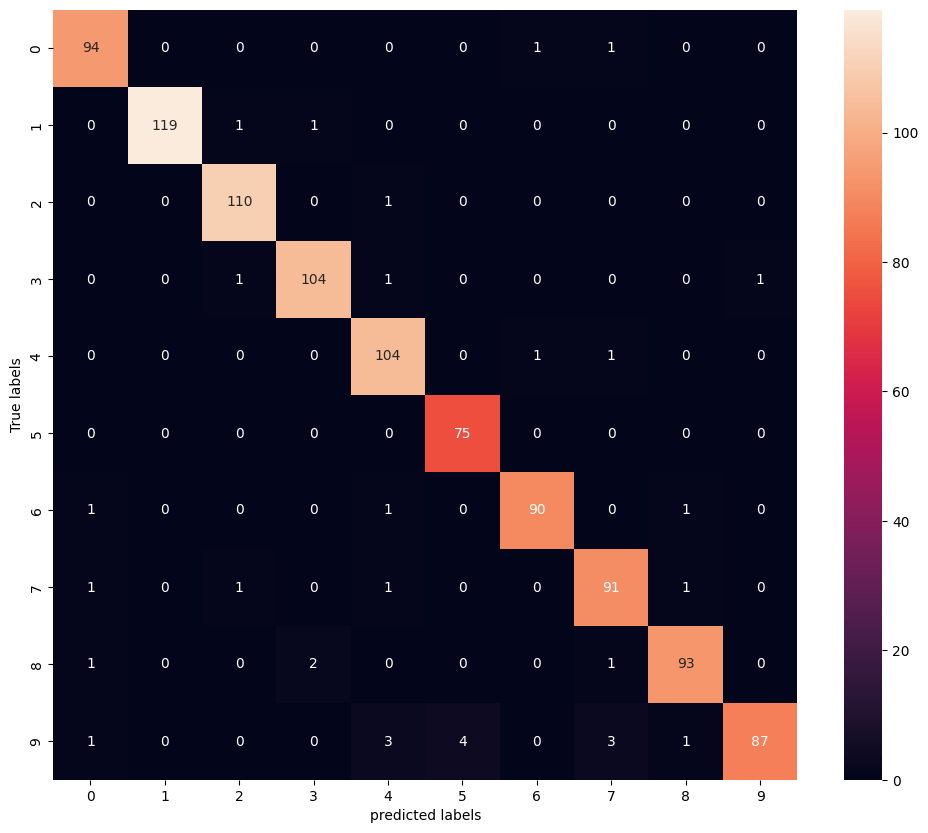

In [46]:
CM = confusion_matrix(label_test, test_label_predicted)

plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');

## 4. (Optional) Simple Image Classification Using the MNIST Dataset - TensorFlow

#### import libraries that we need

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### load MNIST dataset

In [48]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

print('Shape of train_x is : %s (min= %1.2f, max= %1.2f)' % (str(train_x.shape), train_x.min(), train_x.max()))
print('Shape of train_y is : %s (min= %d, max= %d)' % (str(train_y.shape), train_y.min(), train_y.max()))

Shape of train_x is : (60000, 28, 28) (min= 0.00, max= 255.00)
Shape of train_y is : (60000,) (min= 0, max= 9)


#### Scale intensities and expand dimension for channels

In [49]:
train_x = train_x.astype('float') / 255.0
test_x = test_x.astype('float') / 255.0

train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)

print('Shape of train_x is : %s (min= %1.2f, max= %1.2f)' % (str(train_x.shape), train_x.min(), train_x.max()))
print('Shape of train_y is : %s (min= %d, max= %d)' % (str(train_y.shape), train_y.min(), train_y.max()))

Shape of train_x is : (60000, 28, 28, 1) (min= 0.00, max= 1.00)
Shape of train_y is : (60000,) (min= 0, max= 9)


#### Display 25 first samples

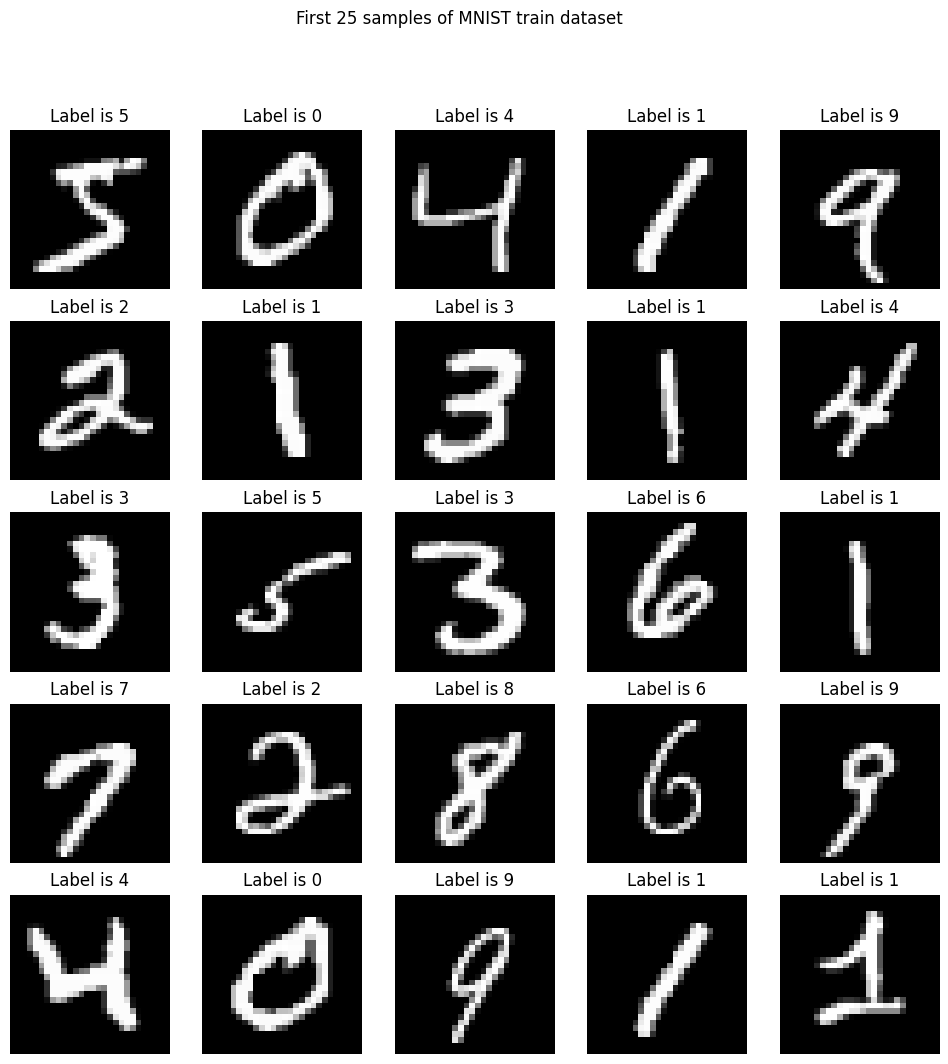

In [50]:
plt.figure(figsize=(12,12))
plt.suptitle('First 25 samples of MNIST train dataset')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title('Label is %d' % train_y[i])
    plt.imshow(train_x[i, :, :, 0], cmap='gray')
    plt.axis('off')

#### Plot the distribution of the dataset

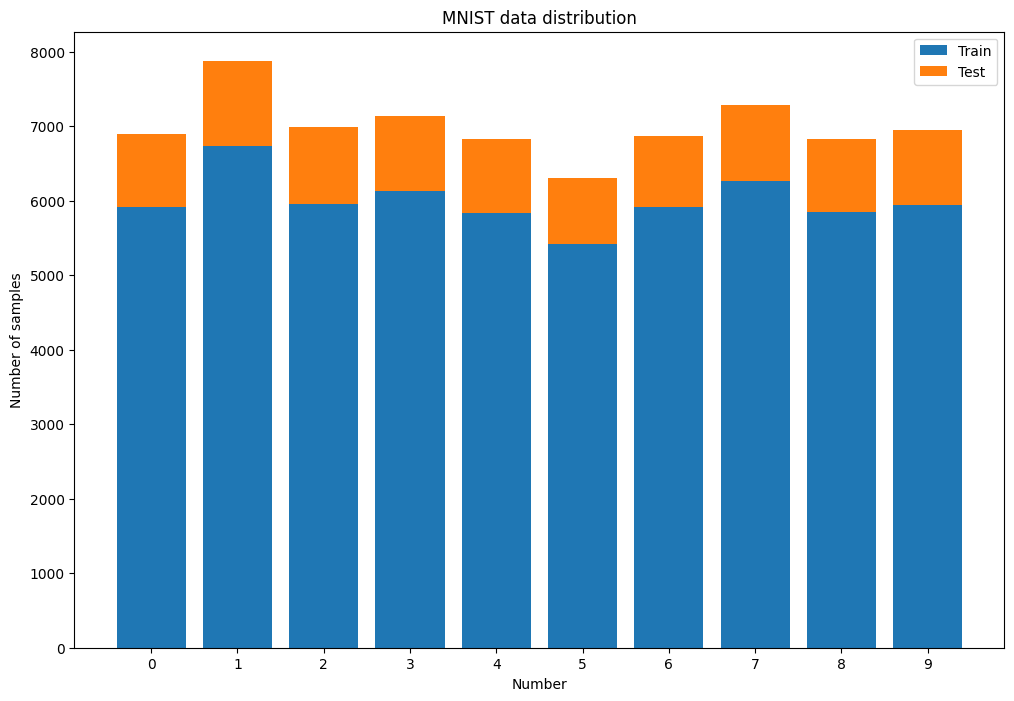

In [51]:
(_, train_count) = np.unique(train_y, return_counts=True)
(_, test_count) = np.unique(test_y, return_counts=True)

plt.figure(figsize=(12,8))
plt.title('MNIST data distribution')
plt.xticks(range(10), labels=range(10))
plt.xlabel('Number')
plt.ylabel('Number of samples')
plt.bar(range(10), train_count, label='Train')
plt.bar(range(10), test_count, label='Test', bottom=train_count)
plt.legend()
plt.savefig('DataDistribution.png')
plt.show()

### A Fully connected (Dense) Model

#### Set number of epochs and Batch size

In [52]:
Epochs = 10
BatchSize = 32

#### Lets start with defining a fully connected network

Model: "DenseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 FlattenLayer (Flatten)      (None, 784)               0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               100480    
                                                                 
 DenseLayer2 (Dense)         (None, 64)                8256      
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


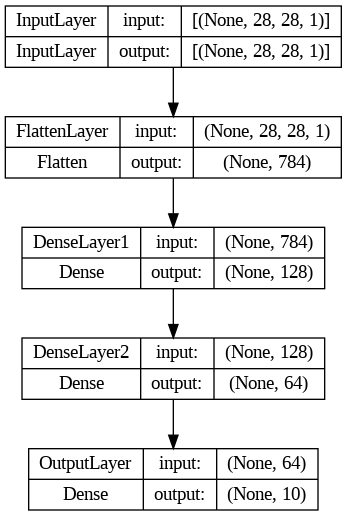

In [53]:
inp = layers.Input(shape=(28,28,1), name='InputLayer')
x = layers.Flatten(name='FlattenLayer')(inp)
x = layers.Dense(128, activation='sigmoid' ,name='DenseLayer1')(x)
x = layers.Dense(64, activation='sigmoid' ,name='DenseLayer2')(x)
outp = layers.Dense(10, activation='softmax' ,name='OutputLayer')(x)

model = Model(inp, outp, name='DenseModel')
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(), metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True, to_file='DenseModel.png')

#### Convert train_y and test_y to one_hot format

In [54]:
one_hot_train_y = to_categorical(train_y, num_classes=10)
one_hot_test_y = to_categorical(test_y, num_classes=10)
print('Shape of one_hot_train_y is : ' + str(one_hot_train_y.shape))
print('Shape of one_hot_test_y is : ' + str(one_hot_test_y.shape))

Shape of one_hot_train_y is : (60000, 10)
Shape of one_hot_test_y is : (10000, 10)


#### Make a directory to save model at the end of each epochs

In [55]:
!mkdir DenseModelCheckPoints

#### Train the model and validate on test set

In [56]:
history = model.fit(train_x, one_hot_train_y,
                    validation_data=(test_x, one_hot_test_y),
                    epochs=Epochs,
                    batch_size=BatchSize,
                    callbacks=[
                        ModelCheckpoint(filepath='DenseModelCheckPoints/best_dense_model.h5', save_best_only=True),
                        ModelCheckpoint(filepath='DenseModelCheckPoints/dense_model_{epoch:02d}.h5', save_best_only=False)])

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4565 - accuracy: 0.8843 - val_loss: 0.2159 - val_accuracy: 0.9342
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1761 - accuracy: 0.9481 - val_loss: 0.1452 - val_accuracy: 0.9549
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1223 - accuracy: 0.9639 - val_loss: 0.1149 - val_accuracy: 0.9639
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0904 - accuracy: 0.9736 - val_loss: 0.1036 - val_accuracy: 0.9664
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0707 - accuracy: 0.9796 - val_loss: 0.0877 - val_accuracy: 0.9730
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0561 - accuracy: 0.9830 - val_loss: 0.0851 - val_accuracy: 0.9729
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0459 - accuracy: 0.9865 - val_loss: 0.0811 - val_accuracy:

#### Plot the learning curve

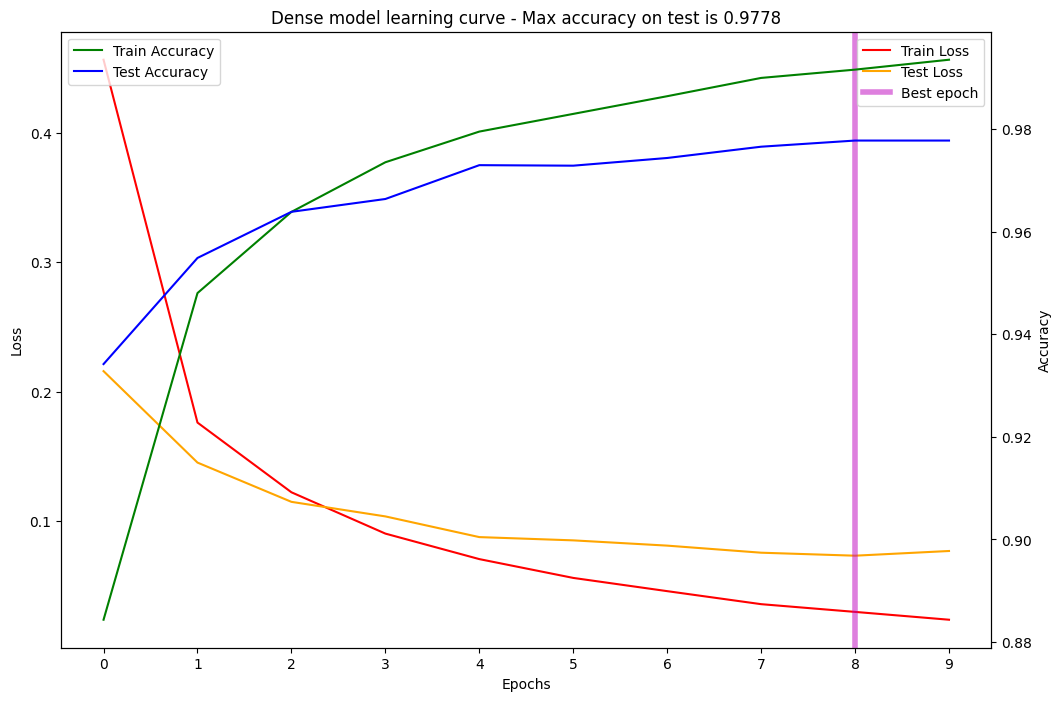

In [57]:
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

fig, ax1 = plt.subplots(figsize=(12,8))
plt.title('Dense model learning curve - Max accuracy on test is %1.4f' % max(history.history['val_accuracy']))

ax1.set_xlabel('Epochs')
ax1.set_xticks(range(Epochs))
ax1.set_ylabel('Loss')
ax1.plot(range(Epochs), history.history['loss'], 'r', label='Train Loss')
ax1.plot(range(Epochs), history.history['val_loss'], 'orange', label='Test Loss')
ax1.axvline(best_epoch, color='m', lw=4, alpha=0.5, label='Best epoch')
ax1.legend()

ax2 = ax1.twinx()

ax2.set_ylabel('Accuracy')
ax2.plot(range(Epochs), history.history['accuracy'], 'g', label='Train Accuracy')
ax2.plot(range(Epochs), history.history['val_accuracy'], 'b', label='Test Accuracy')
ax2.legend()

plt.savefig('DenseModelLearningCurve.png')
plt.show()

#### Load the best model

In [58]:
model = load_model('DenseModelCheckPoints/best_dense_model.h5')

#### Now predict the test set labels

In [59]:
test_y_hat = model.predict(test_x)
print('test_y_hat shape is : ' + str(test_y_hat.shape))

313/313 [==============================] - 1s 2ms/step
test_y_hat shape is : (10000, 10)


#### We need to convert back the labels to actual numbers

In [60]:
test_y_hat = np.argmax(test_y_hat, axis=1)
print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))

Now test_y_hat shape is : (10000,) (min = 0, max = 9)


#### plot first 25 samples in test set and their actual prediction labels

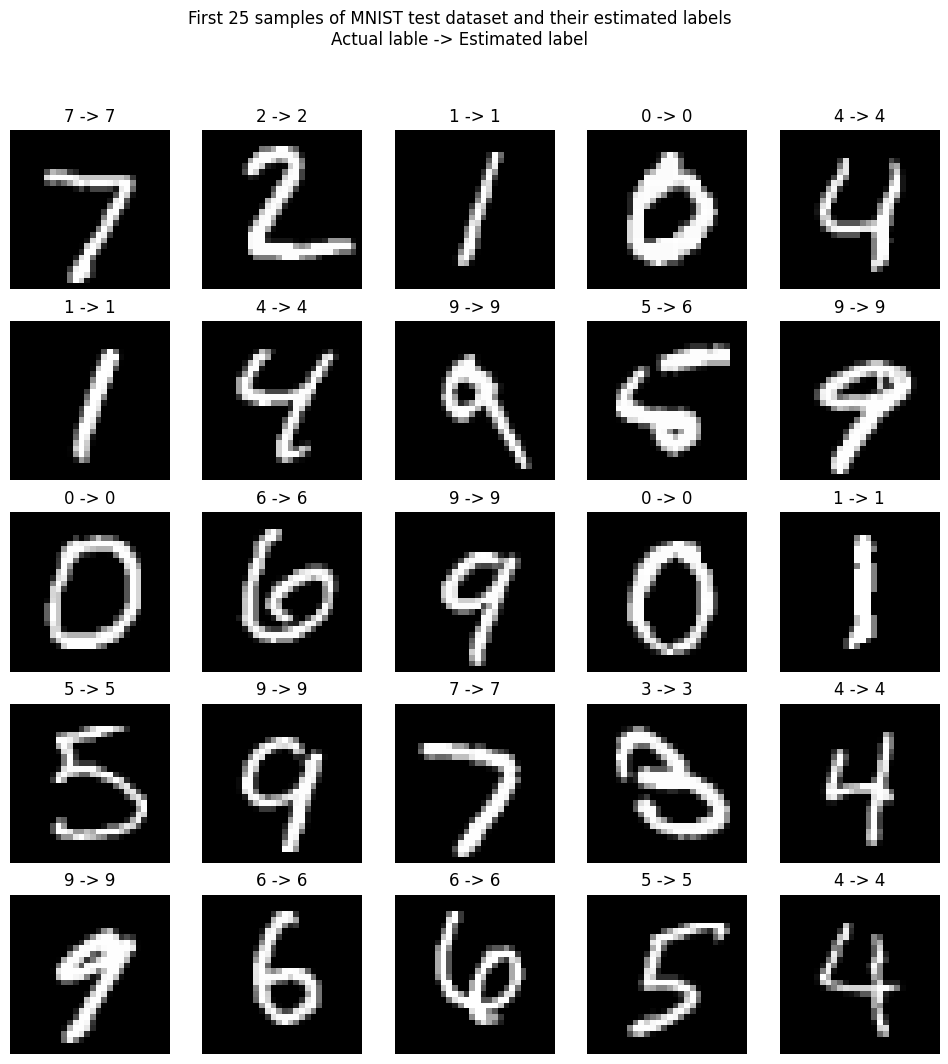

In [61]:
plt.figure(figsize=(12,12))
plt.suptitle('First 25 samples of MNIST test dataset and their estimated labels\nActual lable -> Estimated label')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title('%d -> %d' % (test_y[i], test_y_hat[i]))
    plt.imshow(test_x[i, :, :, 0], cmap='gray')
    plt.axis('off')

#### Find all miss labeled samples and plot the first 25 of those

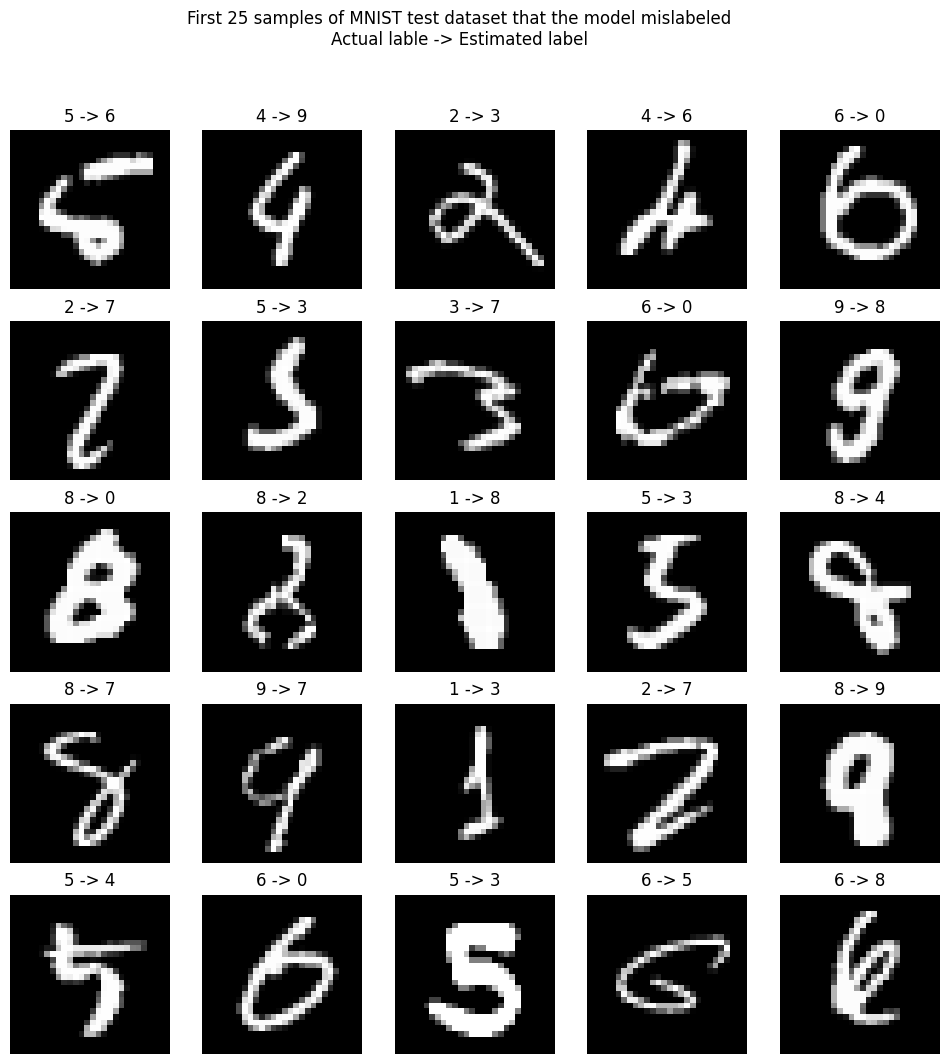

In [62]:
rows = np.where(test_y_hat != test_y)[0]

if len(rows) < 25:
    raise Exception('Mislabeled samples are less than 25 (%d). Perfect model!' % len(rows))

plt.figure(figsize=(12,12))
plt.suptitle('First 25 samples of MNIST test dataset that the model mislabeled\nActual lable -> Estimated label')
for i in range(25):
    index = rows[i]
    plt.subplot(5,5,i+1)
    plt.title('%d -> %d' % (test_y[index], test_y_hat[index]))
    plt.imshow(test_x[index, :, :, 0], cmap='gray')
    plt.axis('off')

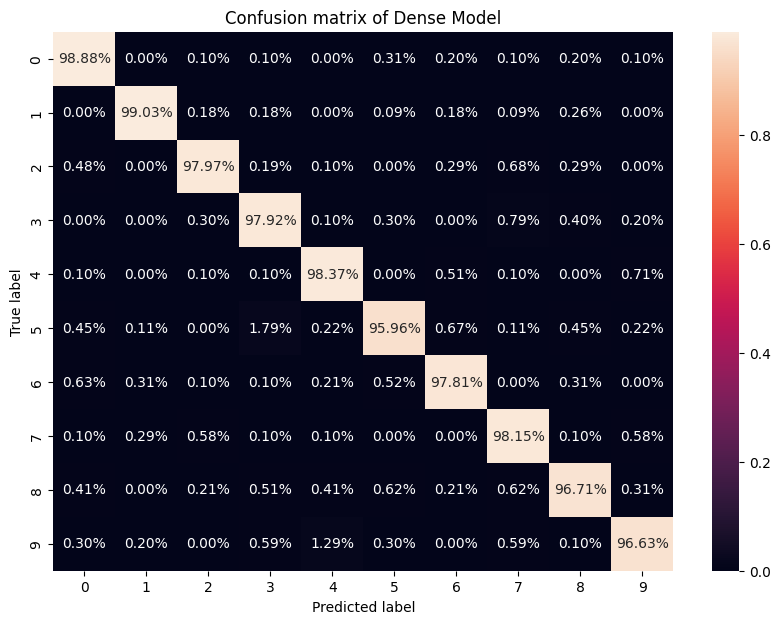

In [63]:
# Show the confusion matrix
cm = confusion_matrix(test_y, test_y_hat, normalize='true')

df_cm = pd.DataFrame(cm, index = [i for i in range(10)],
                     columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
plt.title('Confusion matrix of Dense Model')
sn.heatmap(df_cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Display the classification summary

In [64]:
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)]))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### A Convolutional Model

#### Let's try a convolutional model

Model: "ConvModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 MaxPooling1 (MaxPooling2D)  (None, 13, 13, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 MaxPooling2 (MaxPooling2D)  (None, 3, 3, 64)          0         
                                                                 
 FlattenLayer (Flatten)      (None, 576)               0         
                                                                 
 DenseLayer1 (Dense)         (None, 128)               73

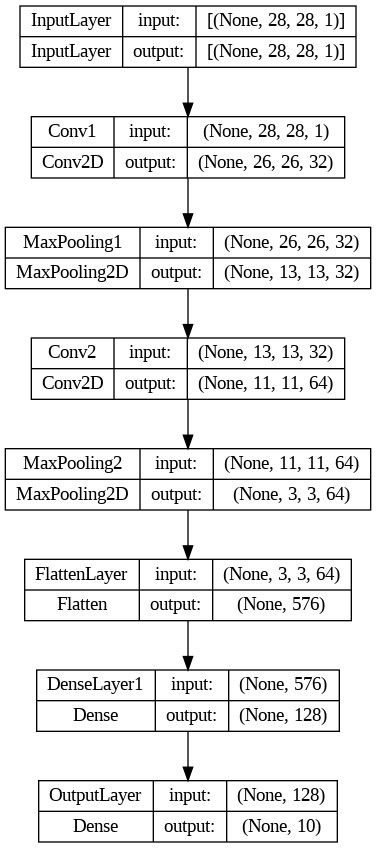

In [65]:
inp = layers.Input(shape=(28,28,1), name='InputLayer')
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv1')(inp)
x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='MaxPooling1')(x)
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2')(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(3,3), name='MaxPooling2')(x)
x = layers.Flatten(name='FlattenLayer')(x)
x = layers.Dense(128, activation='relu' ,name='DenseLayer1')(x)
outp = layers.Dense(10, activation='softmax' ,name='OutputLayer')(x)

model = Model(inp, outp, name='ConvModel')
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(), metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True, to_file='ConvModel.png')

#### Make a directory to save model at the end of each epochs

In [66]:
!mkdir ConvModelCheckPoints

#### Turn on the gpu accelerator to speed up training

In [67]:
history = model.fit(train_x, one_hot_train_y,
                    validation_data=(test_x, one_hot_test_y),
                    epochs=Epochs,
                    batch_size=BatchSize,
                    callbacks=[
                        ModelCheckpoint(filepath='ConvModelCheckPoints/best_conv_model.h5', save_best_only=True),
                        ModelCheckpoint(filepath='ConvModelCheckPoints/conv_model_{epoch:02d}.h5', save_best_only=False)])

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.1603 - accuracy: 0.9503 - val_loss: 0.0722 - val_accuracy: 0.9775
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.0436 - val_accuracy: 0.9852
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0392 - accuracy: 0.9875 - val_loss: 0.0390 - val_accuracy: 0.9875
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0287 - accuracy: 0.9911 - val_loss: 0.0408 - val_accuracy: 0.9865
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0466 - val_accuracy: 0.9853
Epoch 6/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0324 - val_accuracy: 0.9908
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.0333 - val_accuracy

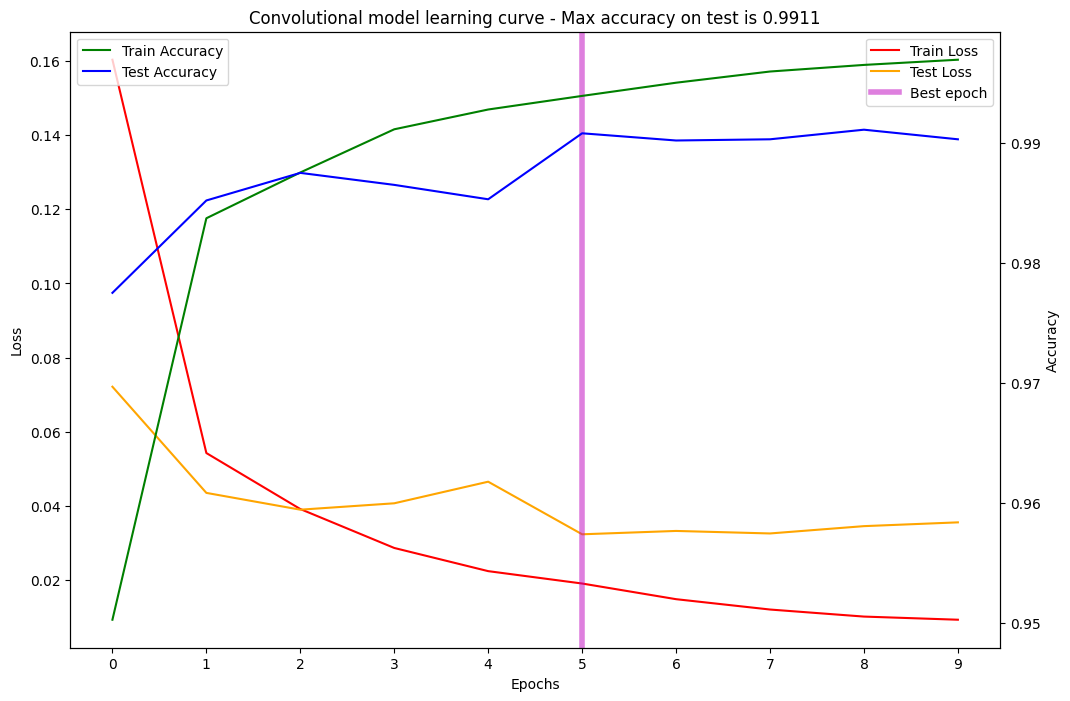

In [68]:
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

fig, ax1 = plt.subplots(figsize=(12,8))
plt.title('Convolutional model learning curve - Max accuracy on test is %1.4f' % max(history.history['val_accuracy']))

ax1.set_xlabel('Epochs')
ax1.set_xticks(range(Epochs))
ax1.set_ylabel('Loss')
ax1.plot(range(Epochs), history.history['loss'], 'r', label='Train Loss')
ax1.plot(range(Epochs), history.history['val_loss'], 'orange', label='Test Loss')
ax1.axvline(best_epoch, color='m', lw=4, alpha=0.5, label='Best epoch')
ax1.legend()

ax2 = ax1.twinx()

ax2.set_ylabel('Accuracy')
ax2.plot(range(Epochs), history.history['accuracy'], 'g', label='Train Accuracy')
ax2.plot(range(Epochs), history.history['val_accuracy'], 'b', label='Test Accuracy')
ax2.legend()

plt.savefig('ConvModelLearningCurve.png')
plt.show()

#### Load the best model

In [69]:
model = load_model('ConvModelCheckPoints/best_conv_model.h5')

#### Now predict the test set labels

In [70]:
test_y_hat = model.predict(test_x)
print('test_y_hat shape is : ' + str(test_y_hat.shape))

313/313 [==============================] - 1s 3ms/step
test_y_hat shape is : (10000, 10)


#### We need to convert back the labels to actual numbers

In [71]:
test_y_hat = np.argmax(test_y_hat, axis=1)
print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))

Now test_y_hat shape is : (10000,) (min = 0, max = 9)


#### plot first 25 samples in test set and their actual prediction labels

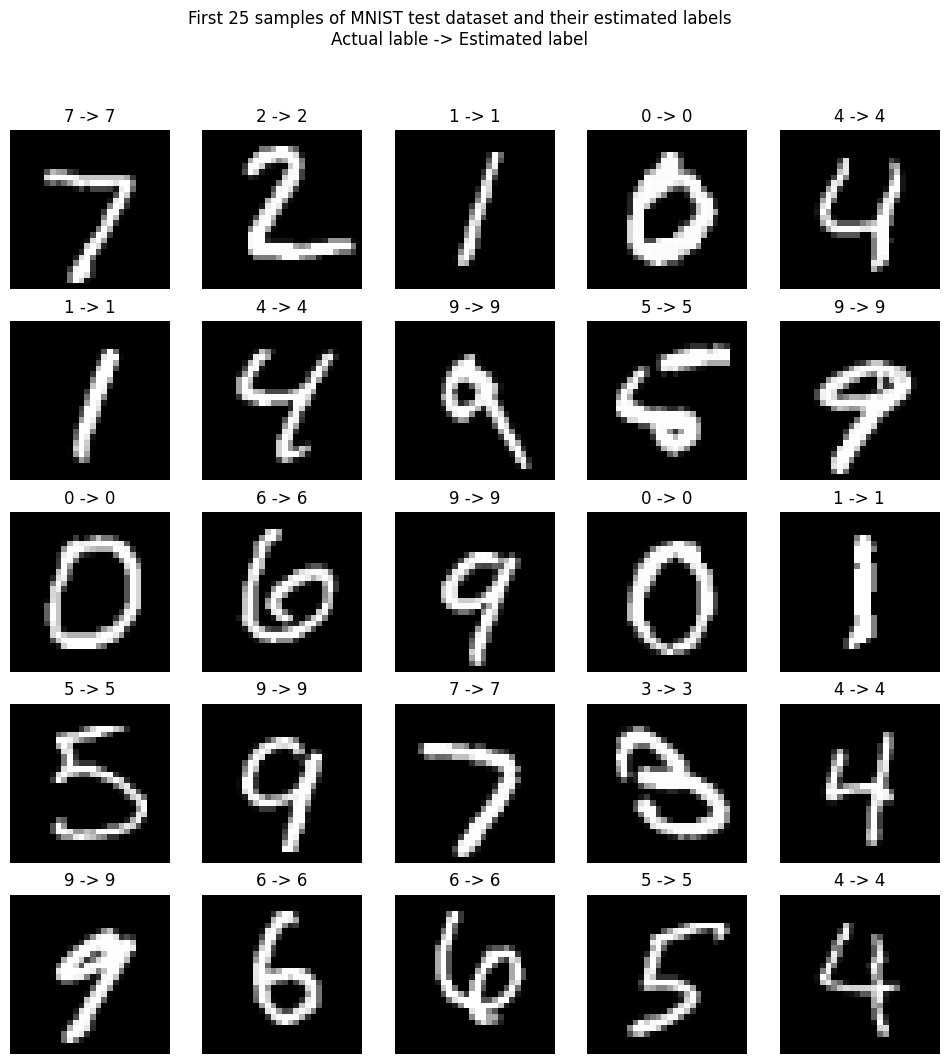

In [72]:
plt.figure(figsize=(12,12))
plt.suptitle('First 25 samples of MNIST test dataset and their estimated labels\nActual lable -> Estimated label')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title('%d -> %d' % (test_y[i], test_y_hat[i]))
    plt.imshow(test_x[i, :, :, 0], cmap='gray')
    plt.axis('off')

#### Find all miss labeled samples and plot the first 25 of those

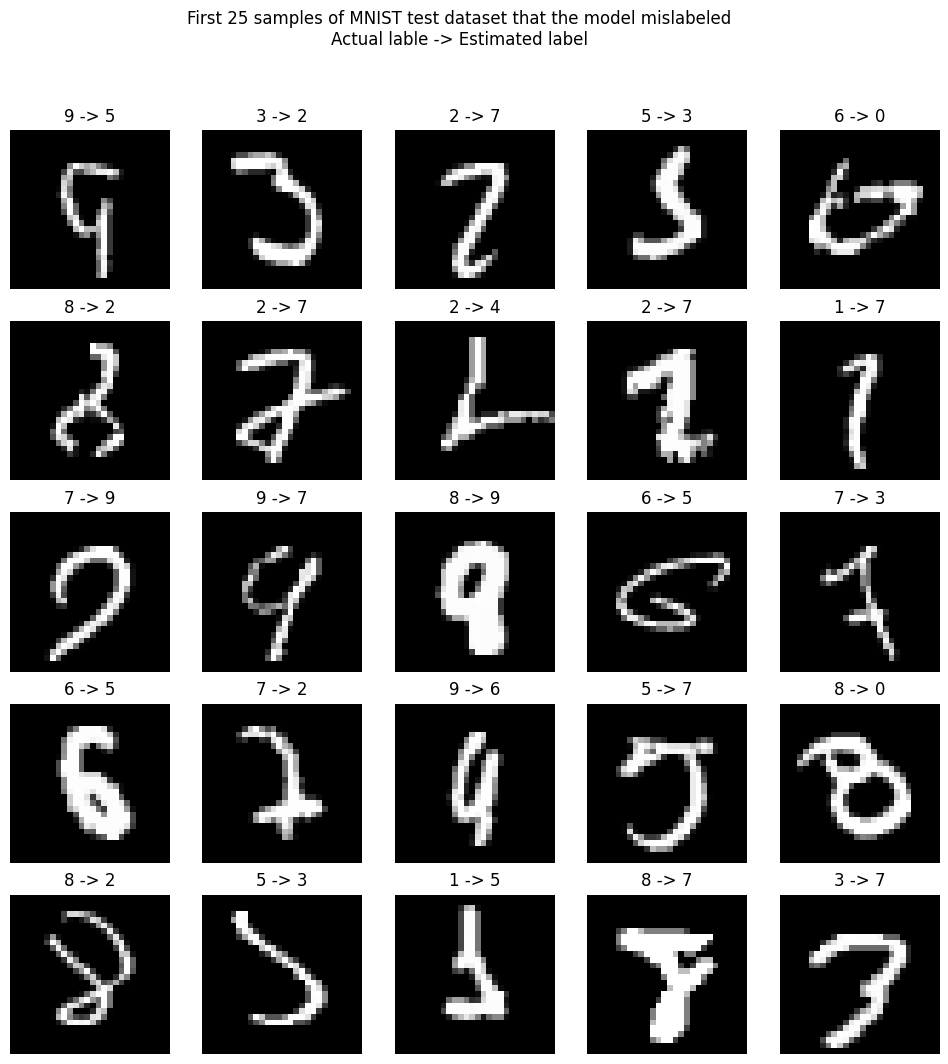

In [73]:
rows = np.where(test_y_hat != test_y)[0]

if len(rows) < 25:
    raise Exception('Mislabeled samples are less than 25 (%d). Perfect model!' % len(rows))

plt.figure(figsize=(12,12))
plt.suptitle('First 25 samples of MNIST test dataset that the model mislabeled\nActual lable -> Estimated label')
for i in range(25):
    index = rows[i]
    plt.subplot(5,5,i+1)
    plt.title('%d -> %d' % (test_y[index], test_y_hat[index]))
    plt.imshow(test_x[index, :, :, 0], cmap='gray')
    plt.axis('off')

#### Show the confusion matrix

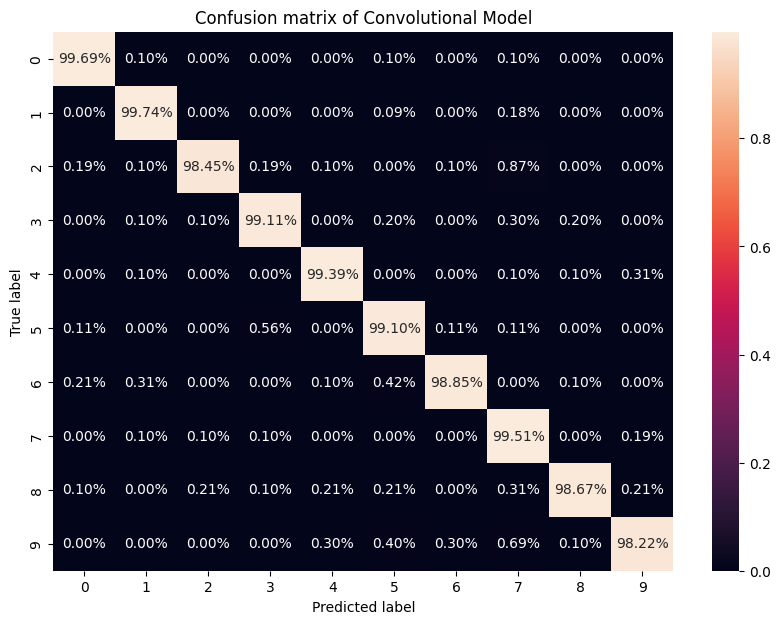

In [74]:
cm = confusion_matrix(test_y, test_y_hat, normalize='true')

df_cm = pd.DataFrame(cm, index = [i for i in range(10)],
                     columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
plt.title('Confusion matrix of Convolutional Model')
sn.heatmap(df_cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Display the classification summary

In [75]:
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)]))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.97      1.00      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

